## Input impedance study

### dependency on biophysical parameters

In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import sys
sys.path.append('/home/yann/work/python_library')
import my_graph as graph
import fourier_for_real as rfft
from signanalysis import autocorrel
sys.path.append('../')
from theory.analytical_calculus import * # where the core calculus lies

# common to all plots, the frequency range we will look at [0.1,1000] Hz
dt, tstop = 1.3e-3, 10.
t = np.arange(int(tstop/dt))*dt
f = rfft.time_to_freq(len(t), dt)

# leaiding data for comp
all_freq, all_psd, all_phase = np.load('../input_impedance_calibration/full_data.npy')


ImportError: No module named 'my_graph'

In [116]:
# building the plotting function

def print_params(soma, stick, params, EqCylinder):
    S = 'soma prop. , L='+str(1e6*soma['L'])+'um, D='+str(1e6*soma['D'])+'um\n'
    S += 'dend prop. , L='+str(1e6*stick['L'])+'um, initial D='+str(1e6*stick['D'])+'um\n'
    S += 'branch prop. , B='+str(len(EqCylinder)-1)+'\n'
    S += 'Cylinders='+str(1e2*EqCylinder)+'%\n'
    S += 'biophys. params. , \n    g_pas='+str(1e-4*params['g_pas'])+' S/cm2, \n       cm='+\
        str(1e2*params['cm'])+\
        ' uF/cm2, Ra='+str(1e2*params['Ra'])+' Ohm.cm'
    return S

          
def get_input_imped(soma, stick, params, EqCylinder1):
    EqCylinder2 = EqCylinder1*stick['L'] # NOW REAL EqCylinder !!
    params_for_cable_theory(stick, params) # setting cable membrane constants
    output = get_the_input_impedance_at_soma(f, EqCylinder2, soma, stick, params)
    psd, phase = np.abs(output)/1e6, (np.angle(output)+np.pi/2.)%(2.*np.pi)-np.pi/2.
    return psd, phase

def make_fig(SET_OF_PSD, SET_OF_PHASE, f, soma, stick, params, EqCylinder,\
            suptitle='varying XX', cb_label='', cb_ticks=None):
    
    fig, AX = plt.subplots(1, 3, figsize=(15,4))
    fig.suptitle(suptitle)
    mymap = graph.get_linear_colormap()

    for psd, phase, r in zip(SET_OF_PSD, SET_OF_PHASE, np.linspace(0,1,len(SET_OF_PSD))):
        AX[0].loglog(f, psd, '-', color=mymap(r,1), ms=5)
        AX[1].semilogx(f, -phase, '-', color=mymap(r,1), ms=5)

    AX[0].plot(all_freq, all_psd, 'kD', ms=2, alpha=.2)
    graph.set_plot(AX[0], xlim=[.08,1200], ylim=[2., 1.2e3],\
                xticks=[1,10,100,1000], yticks=[10,100,1000],\
                xlabel='frequency (Hz)', ylabel='input impedance ($\mathrm{M}\Omega$)')
    AX[1].plot(all_freq, all_phase, 'kD', ms=2, alpha=.2)
    graph.set_plot(AX[1], xlim=[.08,1200], ylim=[-.2,3.7],\
               xticks=[1,10,100,1000], yticks=[0,np.pi/2.,np.pi],\
               yticks_labels=[0,'$\pi/2$', '$\pi$'])
    AX[2].axis('off')
  
    ax_inset=fig.add_axes([0.7,0.1,0.02,0.8])
    cb = graph.build_bar_legend(cb_ticks, ax_inset, mymap, color_discretization=50, label=cb_label)
    AX[2].annotate(print_params(soma, stick, params, EqCylinder), (.5,.3))
    return fig, AX


In [118]:
## A set of baseline parameters

# somatic parameters
soma = {'L': 20*1e-6, 'D': 20*1e-6, 'NSEG': 1, 'exc_density':1e9, 'inh_density':1e9, 'name':'soma'}

# stick parameters
stick = {'L': 600*1e-6, 'D': 1.5e-6, 'B':5 ,'NSEG': 30, 'exc_density':1e9, 'inh_density':1e9, 'name':'dend'}

# branching properties
EqCylinder = np.linspace(0, 1, stick['B']) # equally space branches ! UNITLESS, multiplied only in the func by stick['L']

# biophysical properties
params = {'g_pas': 3.5e-5*1e4, 'cm' : 1.5*1e-2, 'Ra' : 20.*1e-2, 'El': -65e-3,
          'Qe' : 1.e-9 , 'Te' : 5.e-3, 'Ee': 0e-3,\
          'Qi' : 1.5e-9 , 'Ti' : 5.e-3, 'Ei': -80e-3,
          'Ee': 0e-3, 'Ei': -80e-3}

soma, stick, params = np.load('../input_impedance_calibration/mean_model.npy')

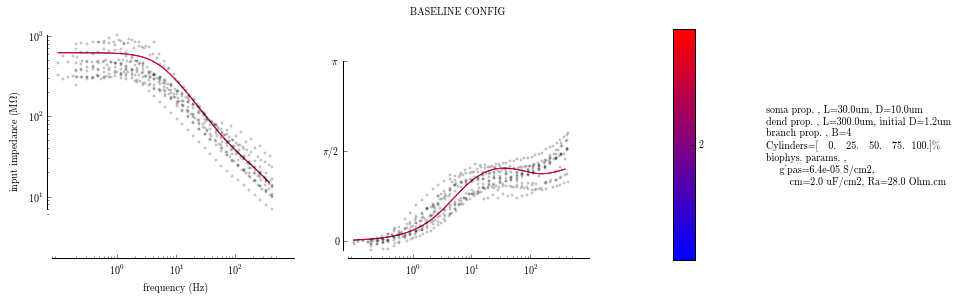

In [119]:
# BASELINE PARAMS

SET_OF_PSD, SET_OF_PHASE = [], []
for i in [1,2]:
    psd, phase = get_input_imped(soma, stick, params, EqCylinder)
    SET_OF_PSD.append(psd)
    SET_OF_PHASE.append(phase)
    
fig, ax = make_fig(SET_OF_PSD, SET_OF_PHASE, f, soma, stick, params, EqCylinder,\
                   cb_ticks=[1,2], cb_label='', suptitle='BASELINE CONFIG')

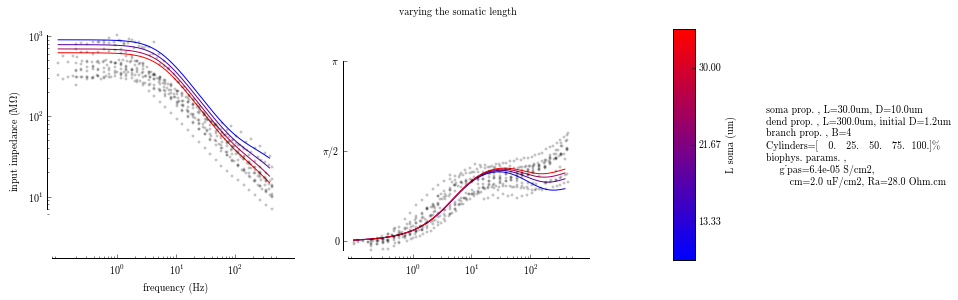

In [121]:
# varying the somatic length

SET_OF_PSD, SET_OF_PHASE = [], []
L = np.linspace(5,30,4)*1e-6
for l in L:
    soma1 = soma.copy()
    soma1['L'] = l
    psd, phase = get_input_imped(soma1, stick, params, EqCylinder)
    SET_OF_PSD.append(psd)
    SET_OF_PHASE.append(phase)
    
fig, ax = make_fig(SET_OF_PSD, SET_OF_PHASE, f, soma, stick, params, EqCylinder,\
                   cb_ticks=1e6*L, cb_label='L soma (um)', suptitle='varying the somatic length')

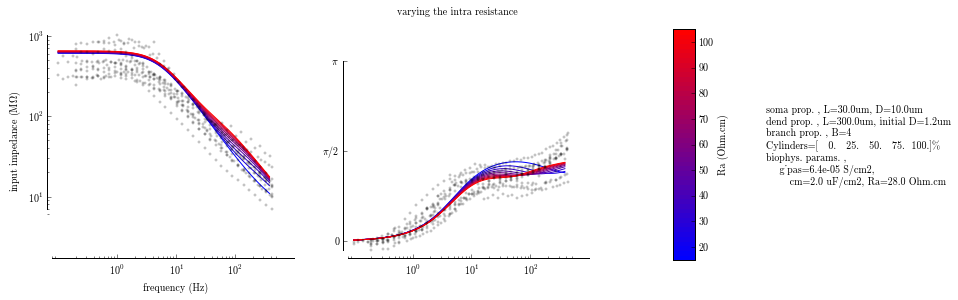

In [122]:
# varying the axial resistance

SET_OF_PSD, SET_OF_PHASE = [], []
Ra = np.linspace(10.,100.,10)*1e-2
for ra in Ra:
    soma1, stick1, params1 = soma.copy(), stick.copy(), params.copy()
    params1['Ra'] = ra
    psd, phase = get_input_imped(soma1, stick1, params1, EqCylinder)
    SET_OF_PSD.append(psd)
    SET_OF_PHASE.append(phase)
    
fig, ax = make_fig(SET_OF_PSD, SET_OF_PHASE, f, soma, stick, params, EqCylinder,\
                   cb_ticks=1e2*Ra, cb_label='Ra (Ohm.cm)', suptitle='varying the intra resistance')

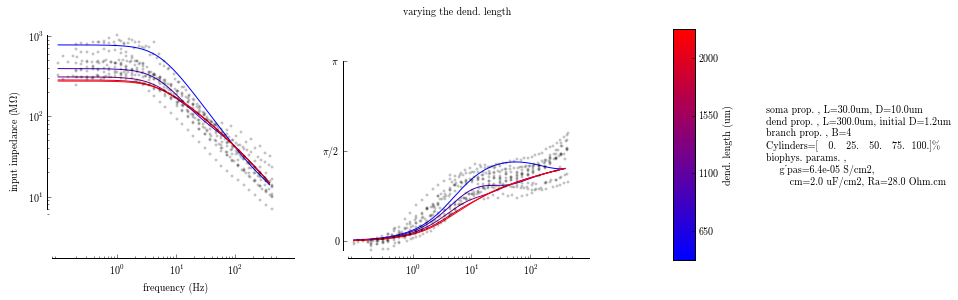

In [123]:
# varying the dendritic length

SET_OF_PSD, SET_OF_PHASE = [], []
L = np.linspace(200.,2000.,5)*1e-6
for l in L:
    soma1, stick1, params1 = soma.copy(), stick.copy(), params.copy()
    stick1['L'] = l
    psd, phase = get_input_imped(soma1, stick1, params1, EqCylinder)
    SET_OF_PSD.append(psd)
    SET_OF_PHASE.append(phase)
    
fig, ax = make_fig(SET_OF_PSD, SET_OF_PHASE, f, soma, stick, params, EqCylinder,\
                   cb_ticks=1e6*L, cb_label='dend. length (um)', suptitle='varying the dend. length')

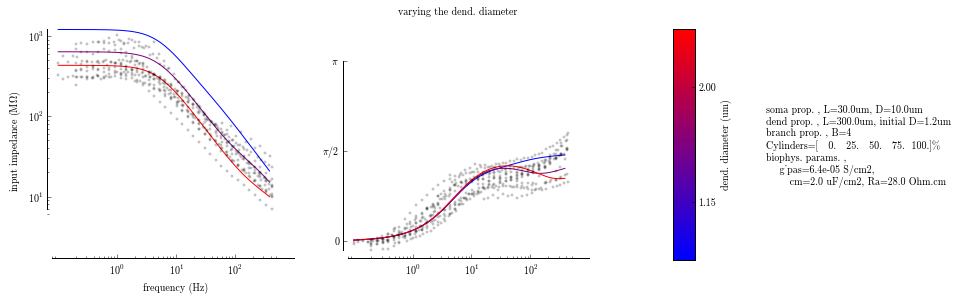

In [124]:
# varying the dendritic diameter

SET_OF_PSD, SET_OF_PHASE = [], []
D = np.linspace(.3,2.,3)*1e-6
for d in D:
    soma1, stick1, params1 = soma.copy(), stick.copy(), params.copy()
    stick1['D'] = d
    psd, phase = get_input_imped(soma1, stick1, params1, EqCylinder)
    SET_OF_PSD.append(psd)
    SET_OF_PHASE.append(phase)
    
fig, ax = make_fig(SET_OF_PSD, SET_OF_PHASE, f, soma, stick, params, EqCylinder,\
                   cb_ticks=1e6*D, cb_label='dend. diameter (um)', suptitle='varying the dend. diameter')

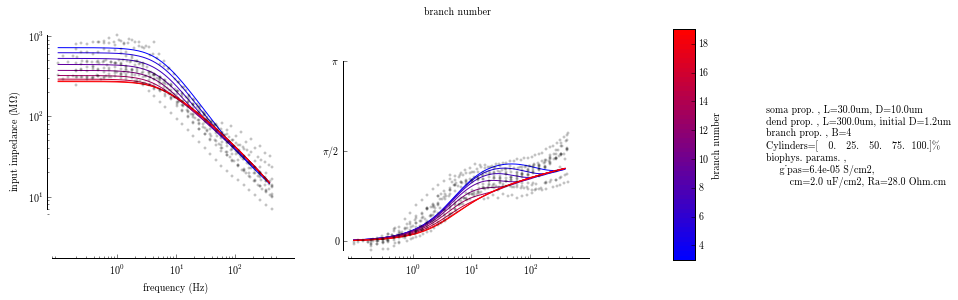

In [125]:
# varying the branch number

SET_OF_PSD, SET_OF_PHASE = [], []
N = np.arange(1,10)*2
for n in N:
    soma1, stick1, params1 = soma.copy(), stick.copy(), params.copy()
    EqCylinder1 = np.linspace(0,1,n+1)
    psd, phase = get_input_imped(soma1, stick1, params1, EqCylinder1)
    SET_OF_PSD.append(psd)
    SET_OF_PHASE.append(phase)
    
fig, ax = make_fig(SET_OF_PSD, SET_OF_PHASE, f, soma, stick, params, EqCylinder,\
                   cb_ticks=N, cb_label='branch number', suptitle='branch number')

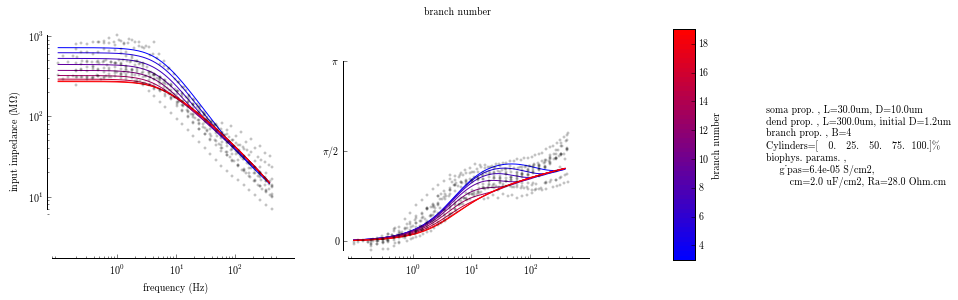

In [126]:
# varying the dendritic length

SET_OF_PSD, SET_OF_PHASE = [], []
N = np.arange(1,10)*2
for n in N:
    soma1, stick1, params1 = soma.copy(), stick.copy(), params.copy()
    EqCylinder1 = np.linspace(0,1,n+1)
    psd, phase = get_input_imped(soma1, stick1, params1, EqCylinder1)
    SET_OF_PSD.append(psd)
    SET_OF_PHASE.append(phase)
    
fig, ax = make_fig(SET_OF_PSD, SET_OF_PHASE, f, soma, stick, params, EqCylinder,\
                   cb_ticks=N, cb_label='branch number', suptitle='branch number')

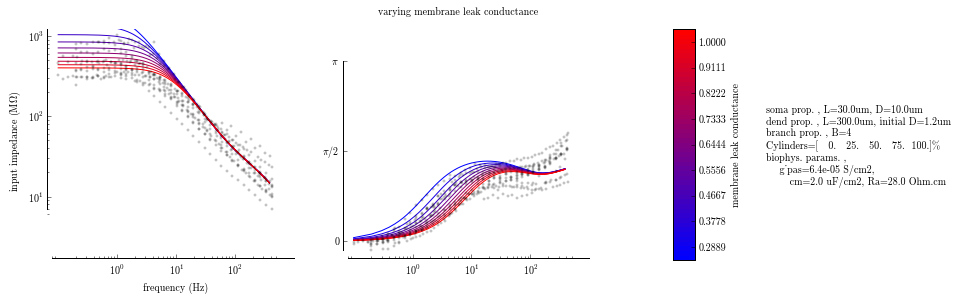

In [127]:
# varying the membrane leak conductance

SET_OF_PSD, SET_OF_PHASE = [], []
G_PAS = np.linspace(2e-5, 1e-4, 10)*1e4
for g_pas in G_PAS:
    soma1, stick1, params1 = soma.copy(), stick.copy(), params.copy()
    params1['g_pas']=g_pas
    psd, phase = get_input_imped(soma1, stick1, params1, EqCylinder)
    SET_OF_PSD.append(psd)
    SET_OF_PHASE.append(phase)
    
fig, ax = make_fig(SET_OF_PSD, SET_OF_PHASE, f, soma, stick, params, EqCylinder,\
                   cb_ticks=G_PAS, cb_label='membrane leak conductance', suptitle='varying membrane leak conductance')

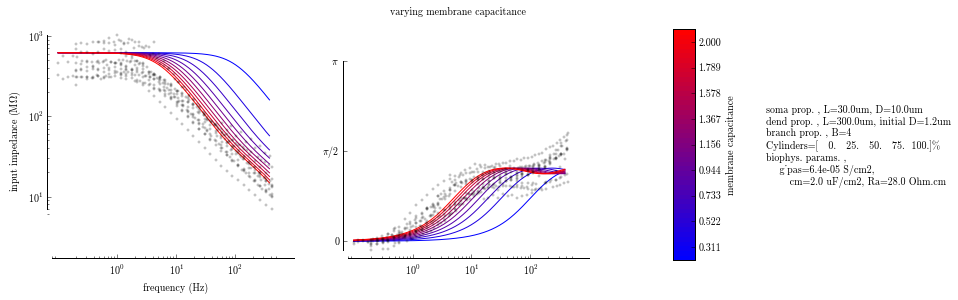

In [128]:
# varying the membrane capacitance

SET_OF_PSD, SET_OF_PHASE = [], []
CM = np.linspace(0.1,2, 10)*1e-2
for cm in CM:
    soma1, stick1, params1 = soma.copy(), stick.copy(), params.copy()
    params1['cm']=cm
    psd, phase = get_input_imped(soma1, stick1, params1, EqCylinder)
    SET_OF_PSD.append(psd)
    SET_OF_PHASE.append(phase)
    
fig, ax = make_fig(SET_OF_PSD, SET_OF_PHASE, f, soma, stick, params, EqCylinder,\
                   cb_ticks=1e2*CM, cb_label='membrane capacitance', suptitle='varying membrane capacitance')